In [2]:
import numpy as np
import torch
from mdof_solutions import add_noise
result_ids = [
    '20240729__spe_inter_40dr_nonerr_duf_5dof_50snr',  # 0
    '20240731__spe_inter_40dr_nonerr_vdp_5dof_50snr',  # 1
    '20240730__spe_inter_40dr_linmod_duf_5dof_50snr',  # 2
    '20240730__spe_inter_40dr_valerr_duf_5dof_50snr',  # 3
    '20240819__spe_inter_40dr_nonerr_duf_5dof_20snr',  # 4
    '20240902__spe_inter_40dr_nonerr_duf_5dof_10snr',  # 5
    '20240923__spe_inter_40dr_nonerr_duf_5dof_50snr',  # 6
    '20240924__spe_inter_40dr_linmod_duf_5dof_50snr',  # 7
    '20240925__spe_inter_40dr_valerr_duf_5dof_50snr',  # 8
    '20240925__spe_inter_40dr_nonerr_vdp_5dof_50snr',  # 9
]
result_id = result_ids[8]
results = torch.load(f'results/{result_id}.pth')
ground_truth = results['ground_truth']
prediction = results['prediction']
alphas = results['alphas']
lin_solution = results['lin_solution']
model_dict = results['model']
prescr_params = results['prescribed_params']
true_params = results['true_params']

n_dof = lin_solution['x'].shape[0]
lin_solution['v'] = lin_solution['xdot']

snr = float(result_id[-5:-3])

print(results.keys())

dict_keys(['alphas', 'test_args', 'param_dropouts', 'true_params', 'prescribed_params', 'pinn_config', 'epoch', 'loss', 'model', 'models', 'ground_truth', 'prediction', 'lin_solution'])


In [1]:
import matplotlib
import shutil
matplotlib.rcParams['text.usetex'] = True

# Check if LaTeX is enabled in rcParams
print("text.usetex:", matplotlib.rcParams['text.usetex'])

# Check if LaTeX binary is in PATH
latex_path = shutil.which("pdflatex")
print("pdflatex path:", latex_path)

# Check if kpsewhich binary is in PATH
kpsewhich_path = shutil.which("kpsewhich")
print("kpsewhich path:", kpsewhich_path)

import os
print(os.environ['PATH'])

text.usetex: True
pdflatex path: /usr/local/texlive/2024basic/bin/universal-darwin/pdflatex
kpsewhich path: /usr/local/texlive/2024basic/bin/universal-darwin/kpsewhich
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/bin:/usr/local/texlive/2024basic/bin/universal-darwin:/Users/marcus/.modular/pkg/packages.modular.com_mojo/bin:/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/bin:/opt/homebrew/Caskroom/miniforge/base/condabin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Applications/VMware Fusion.app/Contents/Public:/Users/marcus/.cargo/bin


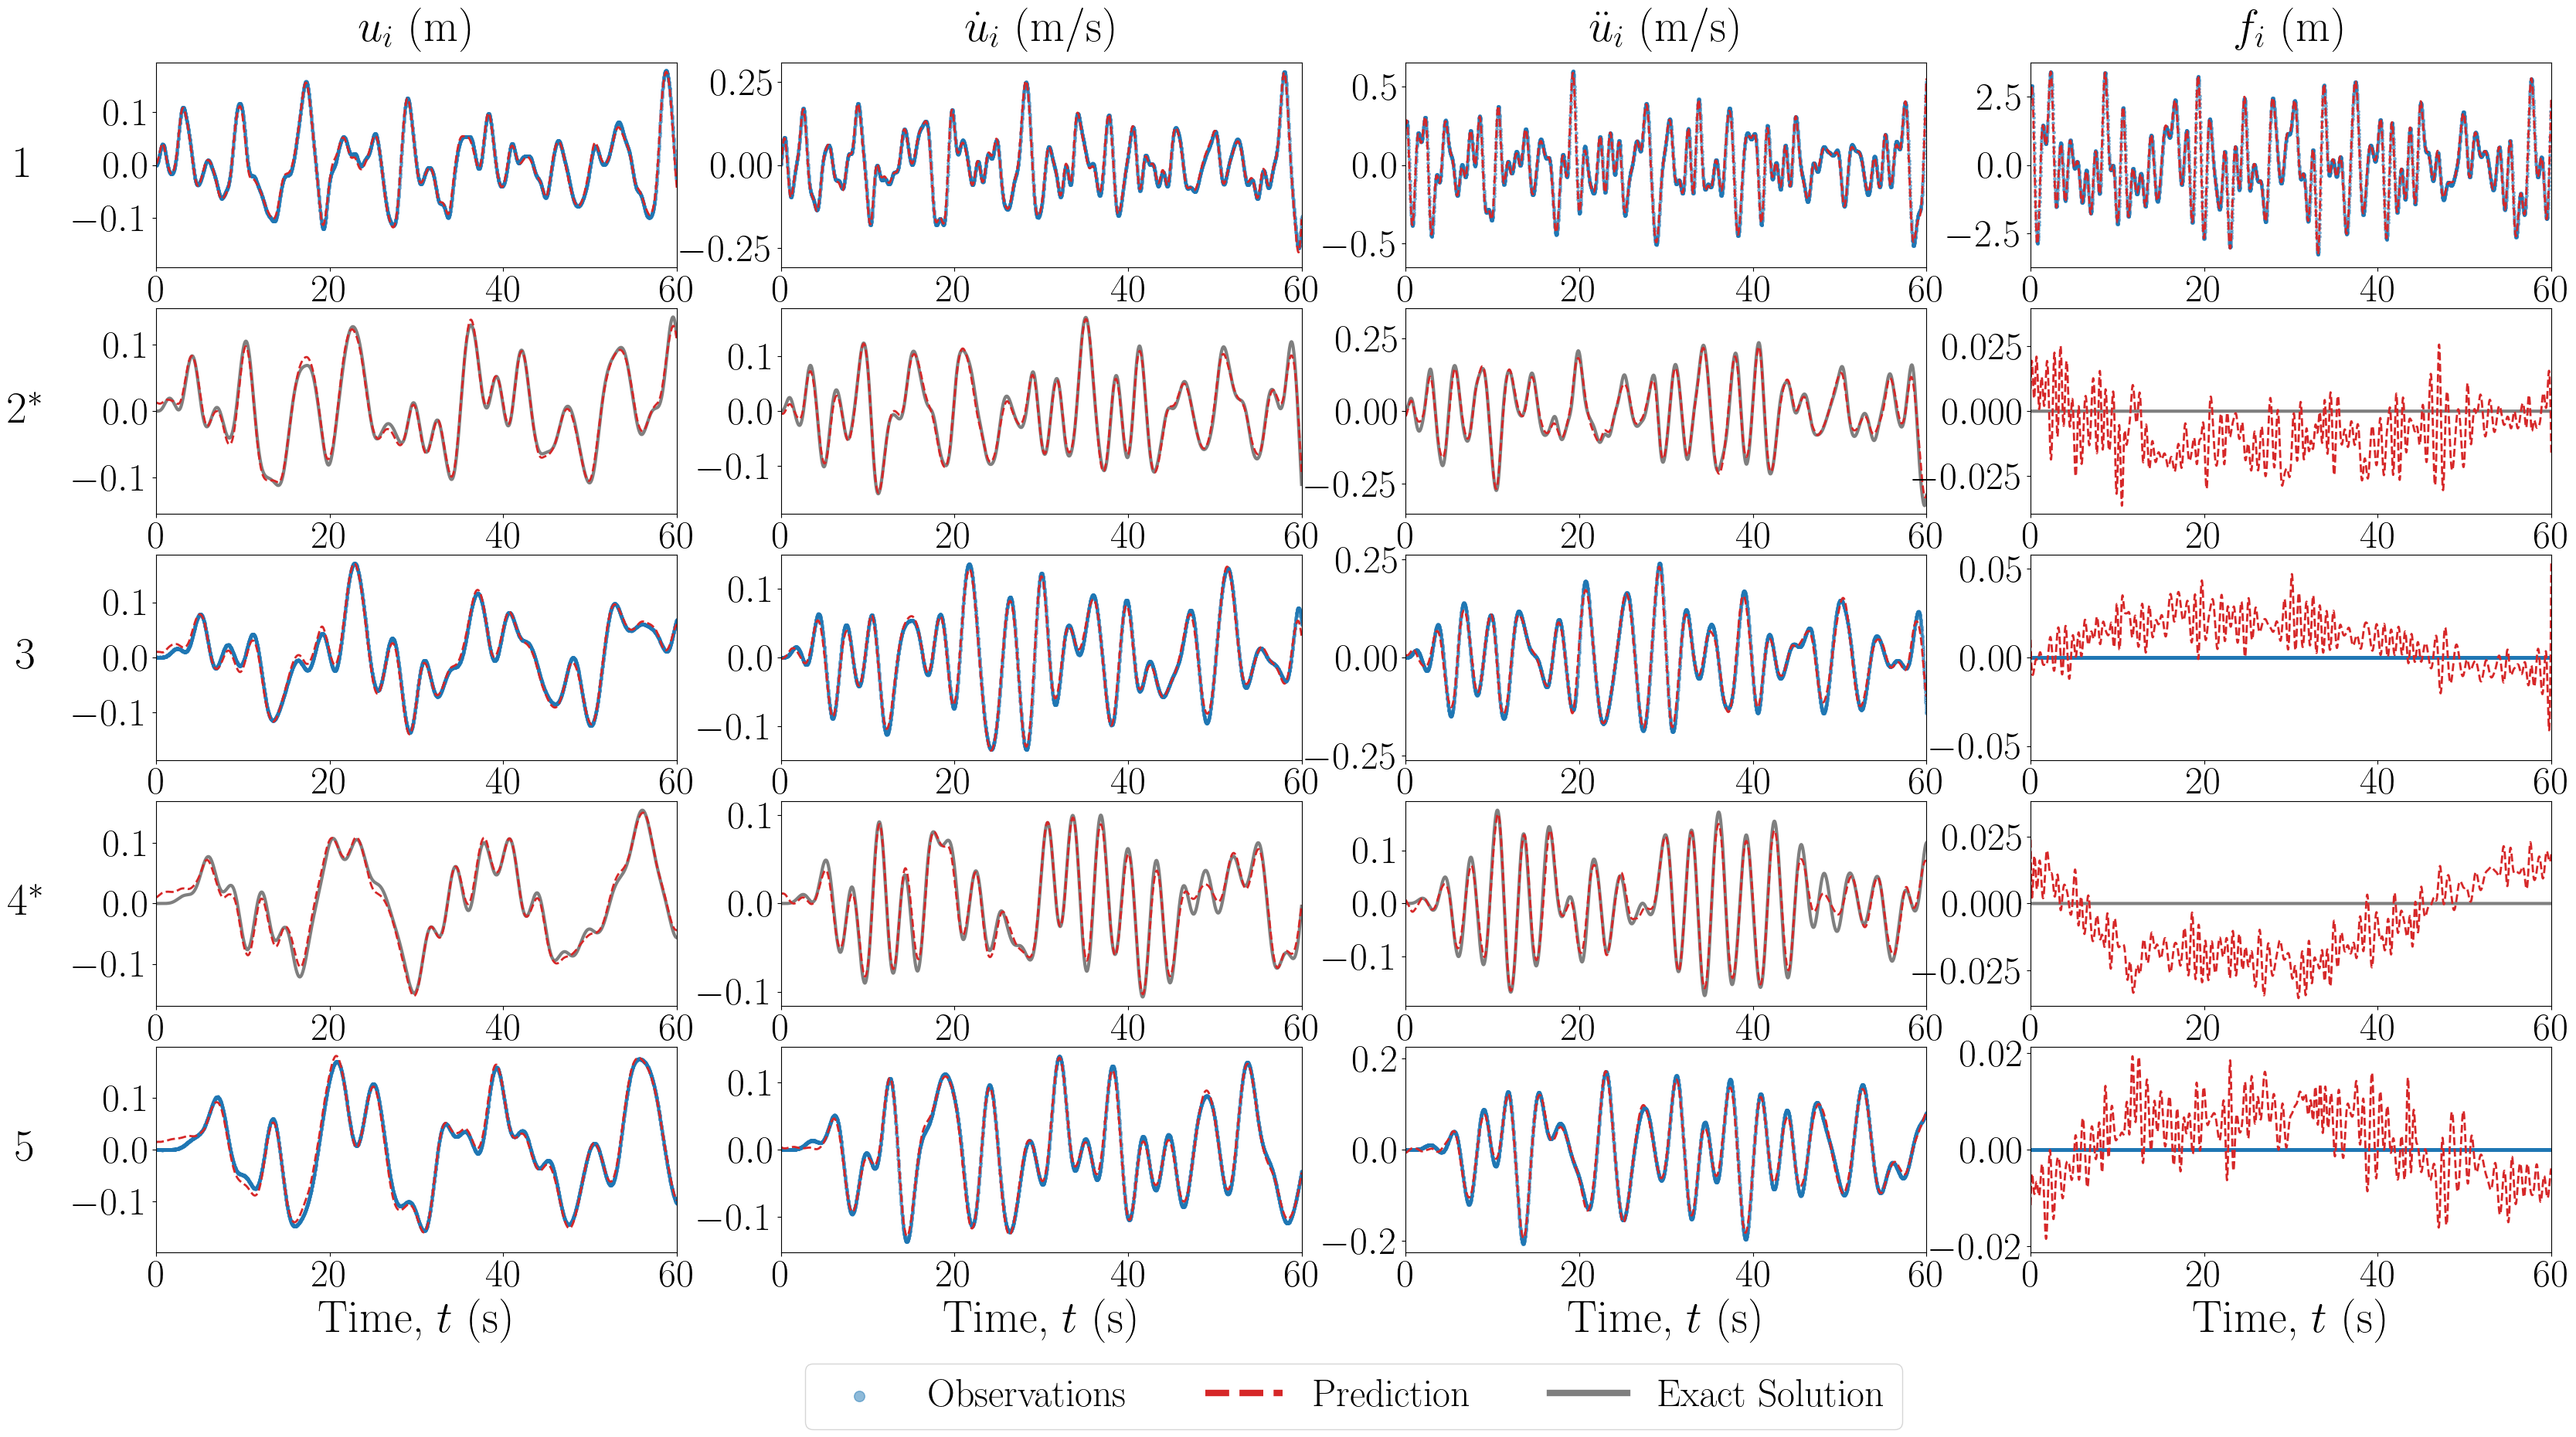

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

fig, axs = plt.subplots(n_dof, 4, figsize = (40, 20), facecolor='w')

dropouts = results['pinn_config']['dropouts']

xL = (np.min(ground_truth['t']), np.max(ground_truth['t']))

to_plot_names = ['x_hat', 'v_hat', 'a_hat', 'f_hat']
big_font_size = 42

axs[0,0].set_title(r'$u_i$ (m)', fontsize=big_font_size, pad=20)
axs[0,1].set_title(r'$\dot{u}_i$ (m/s)', fontsize=big_font_size, pad=20)
axs[0,2].set_title(r'$\ddot{u}_i$ (m/s)', fontsize=big_font_size, pad=20)
axs[0,3].set_title(r'$f_i$ (m)', fontsize=big_font_size, pad=20)

# axs[0,0].text(0.05, 0.888, r'$i$', fontsize=36, transform=plt.gcf().transFigure)

alpha_keys = [name[:-4] for name in to_plot_names]
lin_keys = ['x', 'v', 'acc']

seeds = [43810, 13927, 2024, 1234]

for dof in range(n_dof):
    for kinetic, kinname in enumerate(to_plot_names):
        noisy_gt = add_noise(ground_truth[kinname], SNR=snr, seed = seeds[kinetic])
        axs[dof, kinetic].set_facecolor('white')
        if any(np.array(dropouts)==dof):
            axs[dof, kinetic].plot(ground_truth['t'], ground_truth[kinname][:, dof], color='black', linewidth=3.0, alpha=0.5, label='Exact Solution')
        else:
            axs[dof, kinetic].scatter(ground_truth['t'][::1], noisy_gt[::1, dof], color='tab:blue', s=6, alpha=0.5, label='Observations')
        if all((result_id[-21:-15] == 'linmod', kinetic<3)):
            axs[dof, kinetic].plot(ground_truth['t'], lin_solution[lin_keys[kinetic]][dof, :], color='tab:green', linewidth=2.0, linestyle='-.', label='Linear Solution')
        axs[dof, kinetic].plot(prediction['t_hat']*alphas['t'].item(), prediction[kinname][:,dof]*alphas[alpha_keys[kinetic]].item(), color='tab:red', linewidth=2.0, linestyle='--', label='Prediction')
        axs[dof, kinetic].set_xlim(xL)
        yL = np.max(np.abs(np.array(axs[dof, kinetic].get_ylim())))
        axs[dof, kinetic].set_ylim(-yL, yL)
        if dof == (n_dof-1): axs[dof, kinetic].set_xlabel(r'Time, $t$ (s)', fontsize=big_font_size)
        axs[dof, kinetic].tick_params(axis='both', which='both', labelsize=36)
        # axs[dof, kinetic].set_xticks([])
        # axs[dof, kinetic].set_yticks([])
    
    axs[dof, 0].text(-15, 0, r'$'+f'{dof+1:d}'+'^*$' if any(np.array(dropouts)==dof) else r'$'+f'{dof+1:d}'+'$', fontsize=big_font_size, verticalalignment='center', horizontalalignment='center')
    
if any(n_dof == np.array(dropouts)):
    axs[-1, 1].scatter([], [], color='tab:blue', s=6, alpha=0.5, label='Observations')
else:
    axs[-1, 1].plot([], [], color='black', linewidth=3.0, alpha=0.5, label='Exact Solution')
leg = axs[-1, 1].legend(fontsize=36, loc='upper center', bbox_to_anchor=(1.1, -0.45), ncol=4, markerscale=4.0)
for legobj in leg.get_lines():
    legobj.set_linewidth(6.0)


In [ ]:
fig.savefig(f'results/figs/{result_id[10:]}.png', bbox_inches='tight')
fig.savefig(f'results/figs/{result_id[10:]}.eps', bbox_inches='tight', dpi=72)

In [ ]:
rmse_all = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_obs = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_unobs = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_first = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
rmse_last = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}

fitness_all = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
fitness_obs = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
fitness_unobs = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
fitness_first = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}
fitness_last = {'x' : 0.0,'v' : 0.0,'a' : 0.0,'f' : 0.0}

for dof in range(n_dof):
    for kinetic, kinname in enumerate(to_plot_names):
        ### Calculate performance metrics
        rmse_dof_kin = np.sqrt(np.mean((ground_truth[kinname][:, dof] - prediction[kinname][:, dof]*alphas[alpha_keys[kinetic]].item())**2))
        range_gt = np.max(ground_truth[kinname][:, dof]) - np.min(ground_truth[kinname][:, dof])
        fitness_dof_kin = (1 - rmse_dof_kin / range_gt) * 100
        
        rmse_all[kinname[:-4]] += rmse_dof_kin
        fitness_all[kinname[:-4]] += fitness_dof_kin / n_dof
    
        if dof == 0:
            rmse_first[kinname[:-4]] = rmse_dof_kin
            fitness_first[kinname[:-4]] = fitness_dof_kin
        if dof == n_dof-1:
            rmse_last[kinname[:-4]] = rmse_dof_kin
            fitness_last[kinname[:-4]] = fitness_dof_kin
        
        if any(np.array(dropouts)==dof):
            # Add to NMSE for dropouts
            rmse_unobs[kinname[:-4]] += rmse_dof_kin
            fitness_unobs[kinname[:-4]] += fitness_dof_kin / len(dropouts)
        else:
            # Add to NMSE for observed
            rmse_obs[kinname[:-4]] += rmse_dof_kin
            fitness_obs[kinname[:-4]] += fitness_dof_kin / (n_dof-len(dropouts))

write_str = f'ID: {result_id}\n\n'
write_str += f'Loss: {results["loss"][-1][-1]:.3e}\n\n'

for key, value in fitness_all.items():
    write_str += f'Fitness - All ({key}): {value:.3f}\n'
    write_str += f'Fitness - Observed ({key}): {fitness_obs[key]:.3f}\n'
    write_str += f'Fitness - Unobserved ({key}): {fitness_unobs[key]:.3f}\n'
    write_str += f'Fitness - First ({key}): {fitness_first[key]:.3f}\n'
    write_str += f'Fitness - Last ({key}): {fitness_last[key]:.3f}\n\n'

print(write_str)

ID: 20240925__spe_inter_40dr_valerr_duf_5dof_50snr

Loss: 3.008e-03

Fitness - All (x): 97.797
Fitness - Observed (x): 97.989
Fitness - Unobserved (x): 97.509
Fitness - First (x): 98.640
Fitness - Last (x): 97.382

Fitness - All (v): 98.044
Fitness - Observed (v): 98.483
Fitness - Unobserved (v): 97.385
Fitness - First (v): 99.151
Fitness - Last (v): 98.158

Fitness - All (a): 97.674
Fitness - Observed (a): 98.152
Fitness - Unobserved (a): 96.957
Fitness - First (a): 99.187
Fitness - Last (a): 97.807

Fitness - All (f): -inf
Fitness - Observed (f): -inf
Fitness - Unobserved (f): -inf
Fitness - First (f): 99.589
Fitness - Last (f): -inf




/var/folders/w8/_lnhm_b11w759xx3q8t1l9800000gn/T/ipykernel_6600/2474290634.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  fitness_dof_kin = (1 - rmse_dof_kin / range_gt) * 100


In [ ]:
def print_params(model_dict, alphas):
    for key, value in model_dict.items():
        val_to_print = value * alphas[key[:-2]]
        true_val = true_params[key[:-1]][int(key[-1])]
        percent_error = 100 * (np.abs(val_to_print - true_val)) / true_val
        print(f'{key}: {val_to_print:.3f} --- True: {true_val:.3f} --- Error: {percent_error:.3f}%')

print_params(model_dict, alphas)

print('\n\n')

def print_prescribed_params(prescr_params):
    for key, value in prescr_params.items():
        print(f'{key}: {value}')
        
print_prescribed_params(true_params)

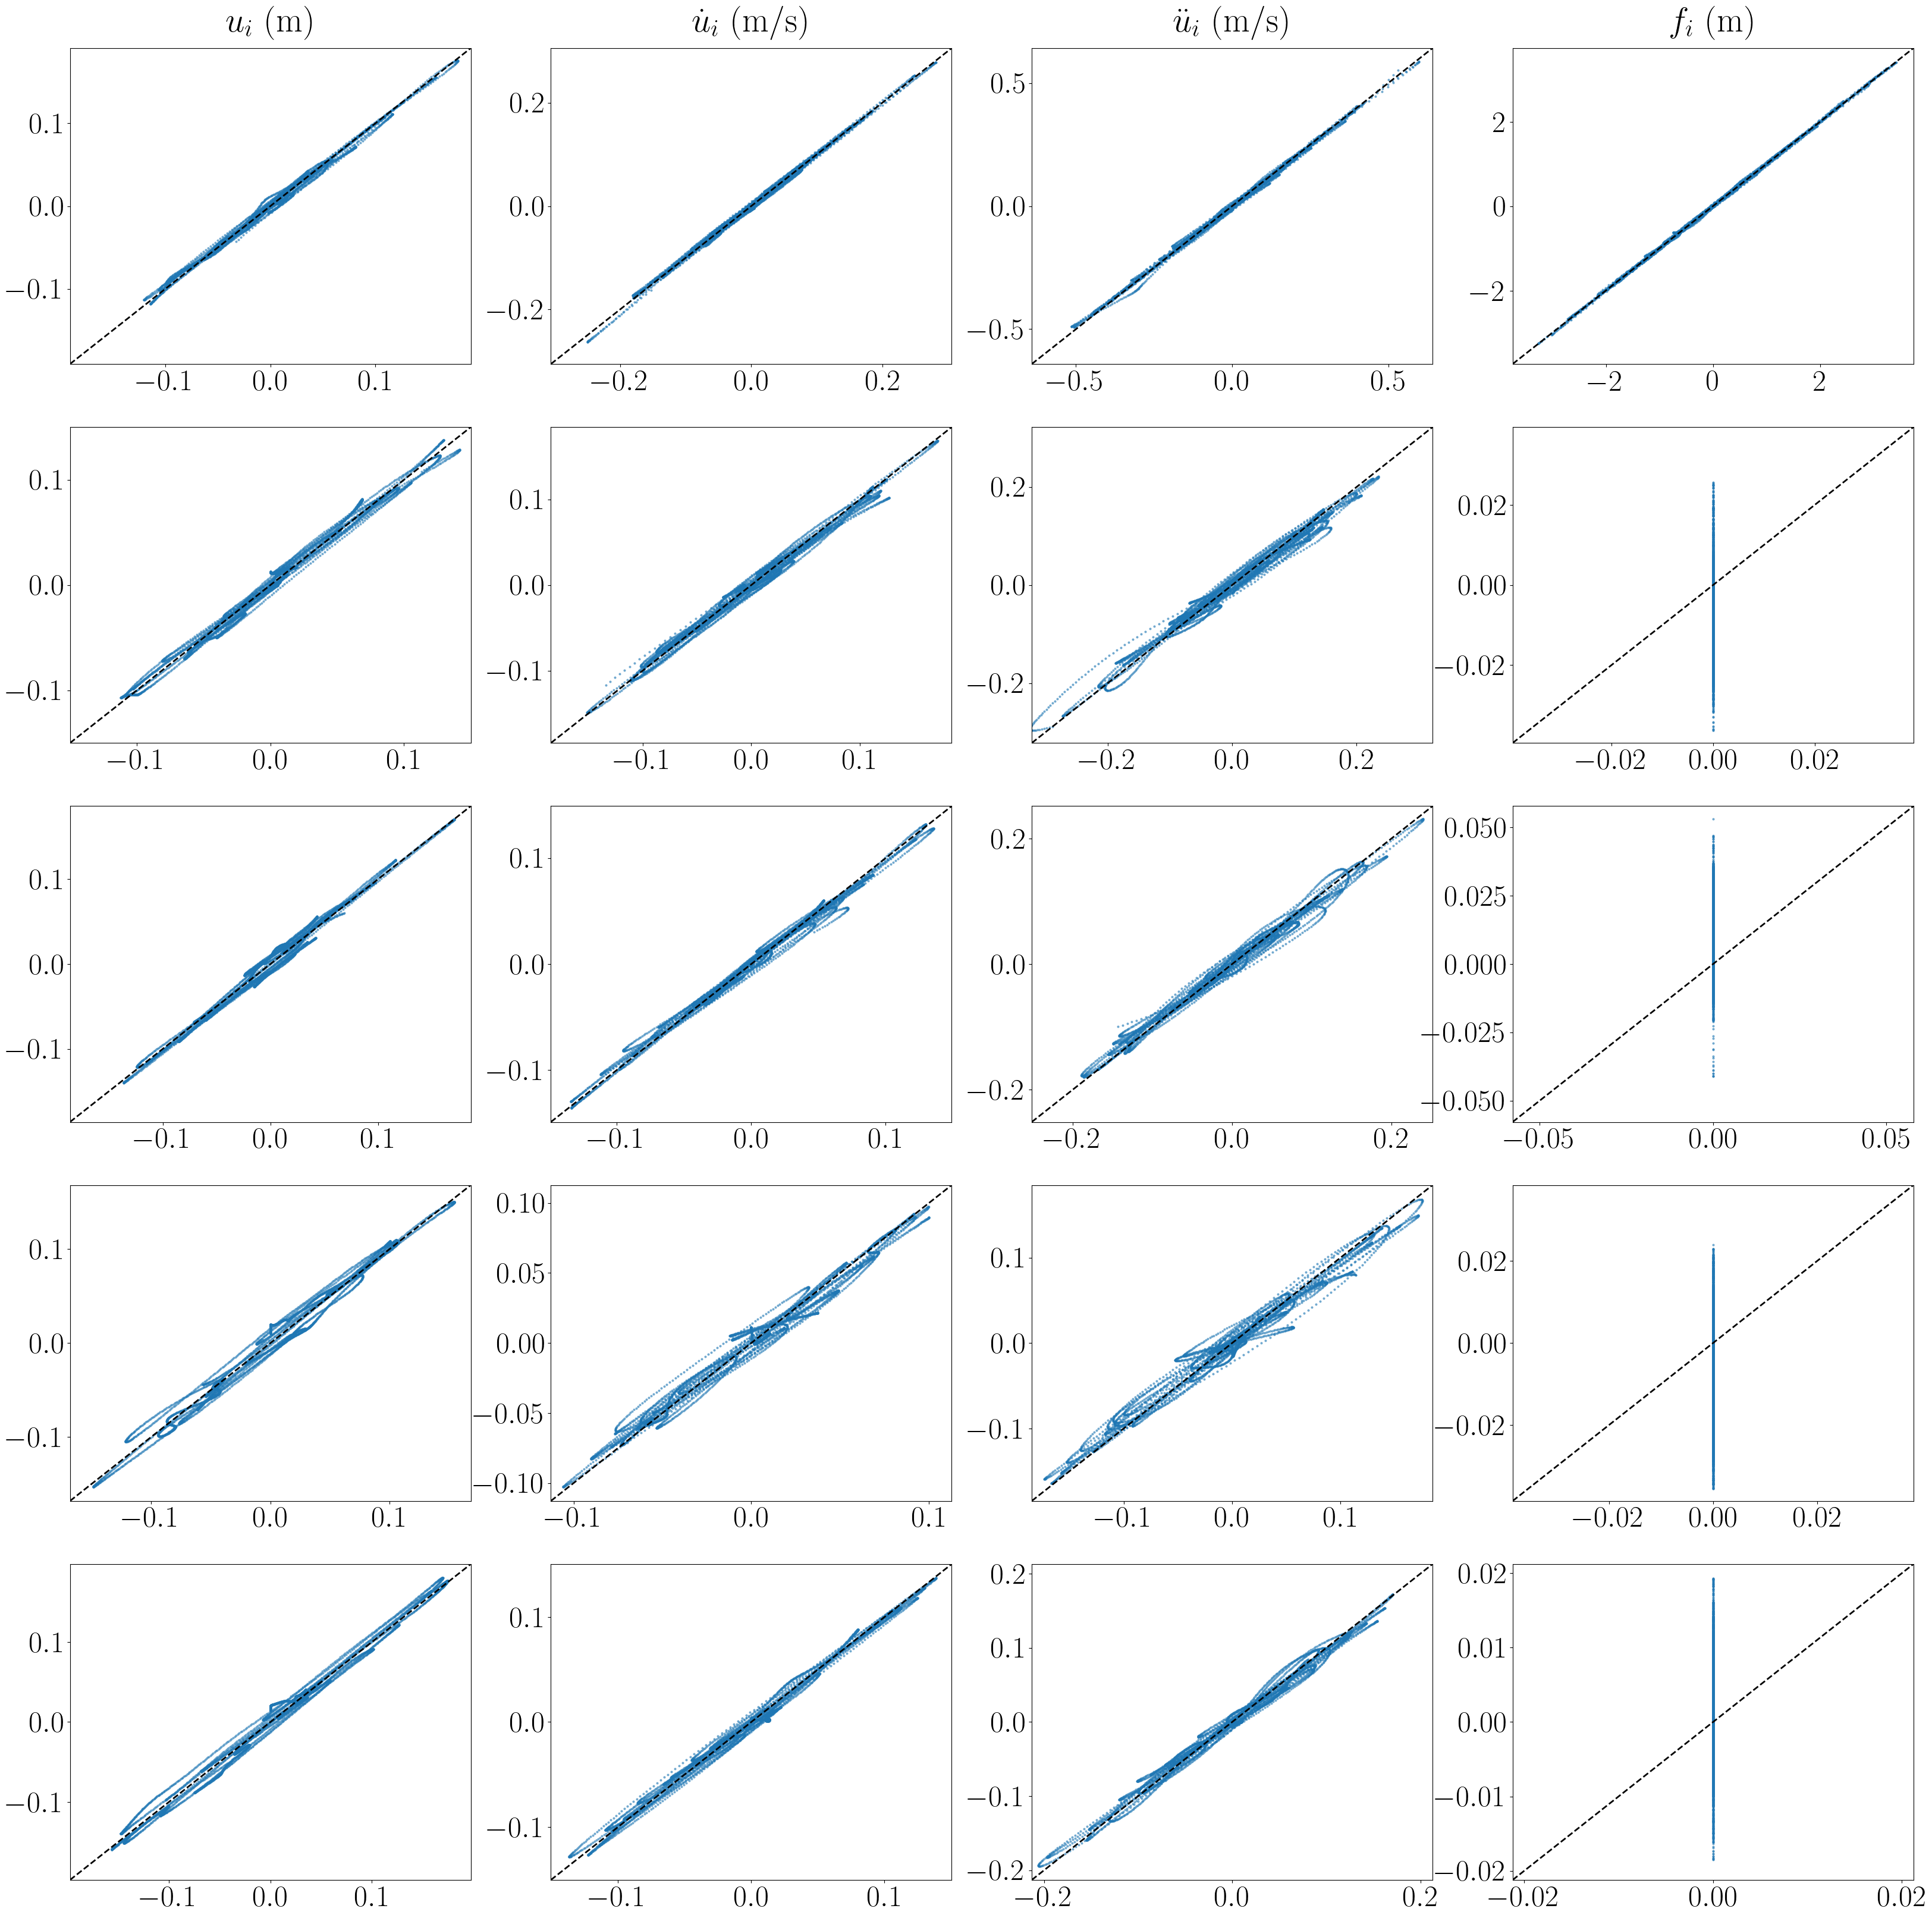

In [8]:
fig, axs = plt.subplots(n_dof, 4, figsize = (40, 40), facecolor='w')

dropouts = results['pinn_config']['dropouts']

xL = (np.min(ground_truth['t']), np.max(ground_truth['t']))

to_plot_names = ['x_hat', 'v_hat', 'a_hat', 'f_hat']
big_font_size = 42

axs[0,0].set_title(r'$u_i$ (m)', fontsize=big_font_size, pad=20)
axs[0,1].set_title(r'$\dot{u}_i$ (m/s)', fontsize=big_font_size, pad=20)
axs[0,2].set_title(r'$\ddot{u}_i$ (m/s)', fontsize=big_font_size, pad=20)
axs[0,3].set_title(r'$f_i$ (m)', fontsize=big_font_size, pad=20)

# axs[0,0].text(0.05, 0.888, r'$i$', fontsize=36, transform=plt.gcf().transFigure)

alpha_keys = [name[:-4] for name in to_plot_names]
lin_keys = ['x', 'v', 'acc']

for dof in range(n_dof):
    for kinetic, kinname in enumerate(to_plot_names):
        axs[dof, kinetic].set_facecolor('white')
        axs[dof, kinetic].scatter(ground_truth[kinname][:, dof], prediction[kinname][:,dof]*alphas[alpha_keys[kinetic]].item(), s=4, alpha=0.5)
        yL = np.max(np.abs(np.array(axs[dof, kinetic].get_ylim())))
        if all((result_id[-21:-15] == 'linmod', kinetic<3)):
            axs[dof, kinetic].scatter(ground_truth[kinname][:, dof], lin_solution[lin_keys[kinetic]][dof, :], s=4, color='tab:green', alpha=0.5, label='Linear Solution')
        axs[dof, kinetic].plot([-yL, yL], [-yL, yL], color='black', linewidth=2.0, linestyle='--')
        axs[dof, kinetic].set_ylim(-yL, yL)
        axs[dof, kinetic].set_xlim(-yL, yL)
        
        # if dof == (n_dof-1): axs[dof, kinetic].set_xlabel(r'Time, $t$ (s)', fontsize=big_font_size)
        axs[dof, kinetic].tick_params(axis='both', which='both', labelsize=36)
    
    # axs[dof, 0].text(-15, 0, r'$'+f'{dof+1:d}'+'^*$' if any(np.array(dropouts)==dof) else r'$'+f'{dof+1:d}'+'$', fontsize=big_font_size, verticalalignment='center', horizontalalignment='center')
    
# if any(n_dof == np.array(dropouts)):
#     axs[-1, 1].scatter([], [], color='tab:blue', s=6, alpha=0.5, label='Observations')
# else:
#     axs[-1, 1].plot([], [], color='black', linewidth=3.0, alpha=0.5, label='Exact Solution')
# leg = axs[-1, 1].legend(fontsize=36, loc='upper center', bbox_to_anchor=(1.1, -0.45), ncol=4, markerscale=4.0)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(6.0)